# Machine Learning Models For Solar Cost Datasets

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
import pandas as pd
import tensorflow as tf
import numpy as np

# import xgboost dependencies
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance

# disable the gpu on mac_m2 so it runs correctly
# https://github.com/keras-team/tf-keras/issues/140
# https://github.com/tensorflow/tensorflow/issues/62361
hw = tf.config.get_visible_devices()
tf.config.set_visible_devices(hw[0])

In [2]:
# import the Utility dataset
utility = 'SCE'
data_file = "DataFrames/df_" + utility + ".csv"

utility_df = pd.read_csv(data_file)

In [3]:
# convert zip code to string
utility_df['Service_Zip'] = utility_df['Service_Zip'].astype(int).astype(str).str.zfill(5)
utility_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347358 entries, 0 to 347357
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Utility                 347358 non-null  object 
 1   Service_City            347358 non-null  object 
 2   Service_Zip             347358 non-null  object 
 3   Service_County          347358 non-null  object 
 4   Technology_Type         347358 non-null  object 
 5   System_Size_AC          347358 non-null  float64
 6   Storage_Size_kW_AC      37372 non-null   float64
 7   Inverter_Size_kW_AC     0 non-null       float64
 8   Mounting_Method         347358 non-null  object 
 9   App_Received_Date       347358 non-null  object 
 10  Installer_Name          347358 non-null  object 
 11  Third_Party_Owned       347358 non-null  object 
 12  Electric_Vehicle        347358 non-null  object 
 13  Total_System_Cost       347358 non-null  float64
 14  Generator_Manufactur

In [5]:
# imput missing values for Storage_Size_kW_AC
utility_df['Storage_Size_kW_AC'] = utility_df['Storage_Size_kW_AC'].fillna(0)
utility_df['Inverter_Size_kW_AC'] = utility_df['Inverter_Size_kW_AC'].fillna(0)
utility_df.isnull().sum()

Utility                   0
Service_City              0
Service_Zip               0
Service_County            0
Technology_Type           0
System_Size_AC            0
Storage_Size_kW_AC        0
Inverter_Size_kW_AC       0
Mounting_Method           0
App_Received_Date         0
Installer_Name            0
Third_Party_Owned         0
Electric_Vehicle          0
Total_System_Cost         0
Generator_Manufacturer    0
Inverter_Manufacturer     0
Generator_Quantity        0
Inverter_Quantity         0
dtype: int64

In [6]:
# see how many installers there are
print("Zipcodes:", utility_df.Service_Zip.nunique())
print("Cities:", utility_df.Service_City.nunique())
print("Installers:", utility_df.Installer_Name.nunique())

Zipcodes: 663
Cities: 382
Installers: 51


In [7]:
#for now lest drop the Generator_Manufacturer and Inverter_Manufacturer manufacturers
#columns_to_drop = ['Utility', 'Service_Zip', 'App_Received_Date', 'Generator_Manufacturer', 'Inverter_Manufacturer']
columns_to_drop = ['Utility', 'Service_Zip', 'App_Received_Date']
#columns_to_drop = ['Utility', 'App_Received_Date']

utility_df.drop(columns=columns_to_drop, inplace=True)
utility_df.head()

,Service_City,Service_County,Technology_Type,System_Size_AC,Storage_Size_kW_AC,Inverter_Size_kW_AC,Mounting_Method,Installer_Name,Third_Party_Owned,Electric_Vehicle,Total_System_Cost,Generator_Manufacturer,Inverter_Manufacturer,Generator_Quantity,Inverter_Quantity
0,DAGGETT,San Bernardino,Solar,137.210,0.0,0.0,Other,Shorebreak,Yes,No,1.653333e+06,SolarWorld,SMA America,508.0,6.0
1,MONROVIA,Los Angeles,Solar,6.903,0.0,0.0,Rooftop,Infinity Energy,No,No,4.125800e+04,Longi Green Energy,SolarEdge,25.0,1.0
2,STRATHMORE,Tulare,Solar,8.640,0.0,0.0,Rooftop,Semper,No,No,4.250000e+04,Sanyo,SolarEdge,16.0,1.0
3,LINDSAY,Tulare,Solar,13.975,0.0,0.0,Rooftop,Other,No,No,3.995000e+04,Other,Fronius,22.0,1.0
4,SANTA CLARITA,Los Angeles,Solar,14.472,0.0,0.0,Rooftop,Other,No,No,3.900000e+04,Other,Enphase,50.0,50.0


In [8]:
# Convert categorical data to numeric with `pd.get_dummies`
cat_columns = utility_df.dtypes[utility_df.dtypes == "object"].index.tolist()

enc = OneHotEncoder(sparse_output=False)
enc_data = enc.fit_transform(utility_df[cat_columns])
enc_columns = enc.get_feature_names_out().tolist()

encode_df = pd.DataFrame(enc_data, columns=enc_columns)
#display(encode_df.head())

# now lets merge the into the application dataframe then drop original columns
utility_df = utility_df.merge(encode_df, left_index=True, right_index=True)
utility_df = utility_df.drop(columns=cat_columns)

print(utility_df.columns)

utility_df.head()

Index(['System_Size_AC', 'Storage_Size_kW_AC', 'Inverter_Size_kW_AC',
       'Total_System_Cost', 'Generator_Quantity', 'Inverter_Quantity',
       'Service_City_ACTON', 'Service_City_ADELANTO', 'Service_City_AGOURA',
       'Service_City_AGOURA HILLS',
       ...
       'Inverter_Manufacturer_SMA America', 'Inverter_Manufacturer_Schneider',
       'Inverter_Manufacturer_SolarBridge', 'Inverter_Manufacturer_SolarEdge',
       'Inverter_Manufacturer_Solaria', 'Inverter_Manufacturer_Solectria',
       'Inverter_Manufacturer_SunPower', 'Inverter_Manufacturer_Sungrow',
       'Inverter_Manufacturer_Tesla', 'Inverter_Manufacturer_Xantrex'],
      dtype='object', length=548)


,System_Size_AC,Storage_Size_kW_AC,Inverter_Size_kW_AC,Total_System_Cost,Generator_Quantity,Inverter_Quantity,Service_City_ACTON,Service_City_ADELANTO,Service_City_AGOURA,Service_City_AGOURA HILLS,...,Inverter_Manufacturer_SMA America,Inverter_Manufacturer_Schneider,Inverter_Manufacturer_SolarBridge,Inverter_Manufacturer_SolarEdge,Inverter_Manufacturer_Solaria,Inverter_Manufacturer_Solectria,Inverter_Manufacturer_SunPower,Inverter_Manufacturer_Sungrow,Inverter_Manufacturer_Tesla,Inverter_Manufacturer_Xantrex
0,137.210,0.0,0.0,1.653333e+06,508.0,6.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6.903,0.0,0.0,4.125800e+04,25.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8.640,0.0,0.0,4.250000e+04,16.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13.975,0.0,0.0,3.995000e+04,22.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14.472,0.0,0.0,3.900000e+04,50.0,50.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Split our preprocessed data into our features and target arrays
y = utility_df['Total_System_Cost']
X = utility_df.drop(columns='Total_System_Cost')

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=55)

In [10]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# set the number of features
number_input_features = X_train.shape[1]
number_input_records = X_train.shape[0]

print("Number of Input Features:", number_input_features)
print("Number of Input Records:", number_input_records)

Number of Input Features: 547
Number of Input Records: 260518


In [11]:
#Basic model Creating an XGBoost regressor
model = xgb.XGBRegressor()

#Training the model on the training data
model.fit(X_train_scaled, y_train)

#Making predictions on the test set
predictions = model.predict(X_test_scaled)

In [12]:
# Calculate the mean squared error and R-squared score
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)

Root Mean Squared Error: 25669.943300301125
R-squared Score: 0.7007981314068304


In [13]:
# specify model and parameter range for grid search CV
# https://www.kaggle.com/code/jayatou/xgbregressor-with-gridsearchcv
# https://github.com/albertkklam/XGBRegressor/blob/master/XGBRegressor.ipynb
estimator = xgb.XGBRegressor(
    objective= 'reg:squarederror',
    learning_rate = 0.01,
    gamma = 0.1,
    subsample = 0.8,
    colsample_bytree = 0.8,
    reg_alpha = 1,
    reg_lambda = 1,
    #nthread=8,
    seed=42
)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(50, 500, 50)
}

# specify the grid search object
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1,
    cv = 3,
    verbose=True
)

In [14]:
%%time
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/opt/homebrew/Caskroom/miniforge/base/envs/tf-gpu/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 2min 7s, sys: 34.9 s, total: 2min 42s
Wall time: 11min 36s


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0.1,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.01, max...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': range(2, 10),
                         'n_estimators': range(50, 500, 50)},
             scoring='neg_mean_squared_error', verbose=True)

In [15]:
# see the best parameters https://www.projectpro.io/recipes/find-optimal-parameters-using-gridsearchcv
print(" Results from Grid Search")
print("\n The best estimator across ALL searched params:\n", grid_search.best_estimator_)
print("\n The best score across ALL searched params:\n", grid_search.best_score_)
print("\n The best parameters across ALL searched params:\n", grid_search.best_params_)

 Results from Grid Search

 The best estimator across ALL searched params:
 XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=450, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

 The best score across ALL searched params:
 -716243839.8267508

 The best parameters across ALL searched params:
 {'max_depth': 9, 'n_estimators': 450}


In [16]:
# Calculate the mean squared error and R-squared score
model = grid_search.best_estimator_
predictions = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)

Root Mean Squared Error: 25768.24411277538
R-squared Score: 0.6985022087887007


<BarContainer object of 20 artists>

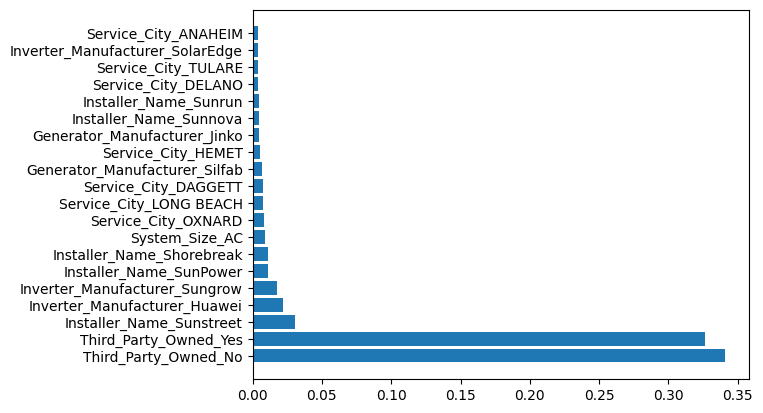

In [17]:
# plot feature importance
n_top_features = 20
sorted_idx = model.feature_importances_.argsort()[::-1]

top_features = X_test.columns[sorted_idx][:n_top_features ].tolist()

plt.barh(X_test.columns[sorted_idx][:n_top_features ], model.feature_importances_[sorted_idx][:n_top_features ])

In [18]:
# save the model for future use
model_file = "models/xgb_model-" + utility + ".json"
model.save_model(model_file)